In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from typing import Union

from cpsplines.graphics.plot_curves import CurvesDisplay
from cpsplines.graphics.plot_surfaces import SurfacesDisplay
from cpsplines.fittings.fit_cpsplines import CPsplines
from cpsplines.utils.rearrange_data import grid_to_scatter

The dataset `faithful` contains the waiting time between eruptions and the
duration of the eruption for the Old Faithful geyser in Yellowstone National
Park, Wyoming, USA. Hence, the columns are:
* `eruptions`: Eruption time (in mins)
* `waiting`: Waiting time to next eruption (in mins)

In [3]:
faithful = pd.read_csv("../data/faithful.csv")

Fit a smooth curve through a series of counts (`waiting` vs `eruptions`) and
plot the results.

In [4]:
example_1 = CPsplines(deg=(3,), ord_d=(2,), n_int=(10,), family="poisson")

example_1.fit(data=faithful, y_col="waiting")

[Solve the problem with smoothing parameters (425.47814993269486,): ] Elapsed time (s): 0.041198


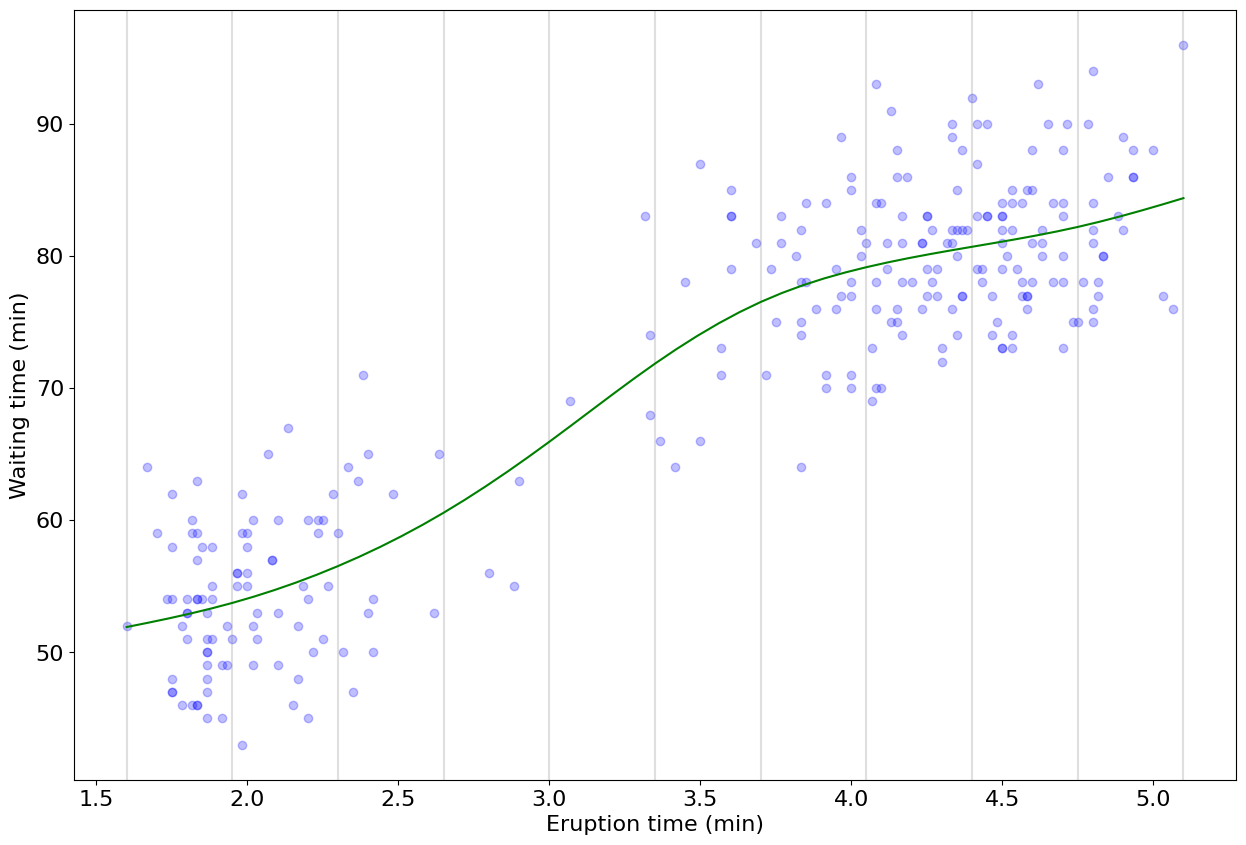

In [5]:
plot1 = CurvesDisplay.from_estimator(
    example_1,
    X=faithful["eruptions"],
    y=faithful["waiting"],
    knot_positions=True,
    col_pt="b",
    **{"c": "g"}
)
_ = plot1.ax_.set_xlabel("Eruption time (min)", fontsize=16)
_ = plot1.ax_.set_ylabel("Waiting time (min)", fontsize=16)
_ = plot1.ax_.tick_params(axis="both", which="major", labelsize=16)

We can also perform out-of-range prediction with Poisson data. For example, let
us predict the responses over the interval $[1, 6]$, which implies a backwards
and forward prediction.

In [6]:
example_2 = CPsplines(
    deg=(3,), ord_d=(2,), n_int=(10,), x_range={"eruptions": (1, 6)}, family="poisson"
)

example_2.fit(data=faithful, y_col="waiting")

[Solve the problem with smoothing parameters (416.7139235062119,): ] Elapsed time (s): 0.031999


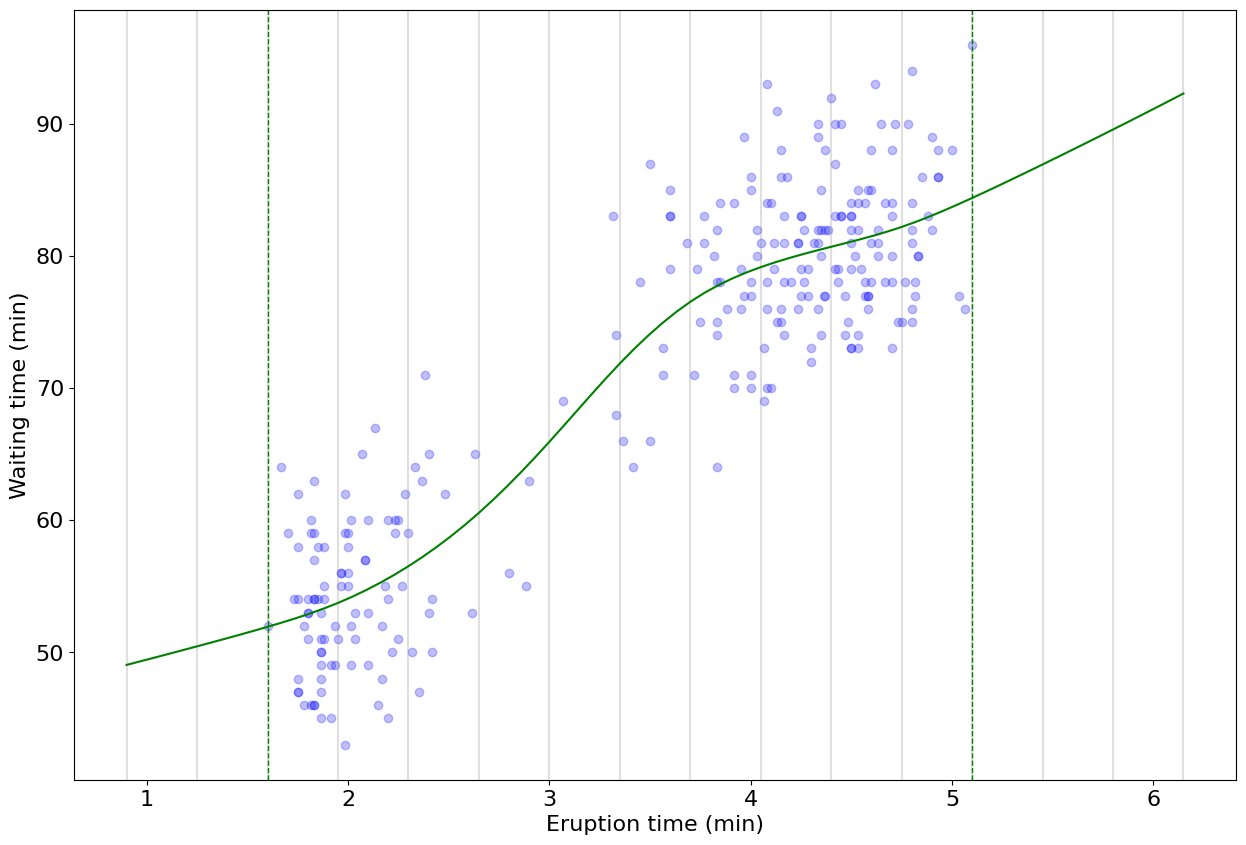

In [7]:
plot2 = CurvesDisplay.from_estimator(
    example_2,
    X=faithful["eruptions"],
    y=faithful["waiting"],
    knot_positions=True,
    col_pt="b",
    **{"c": "g"}
)
_ = plot2.ax_.set_xlabel("Eruption time (min)", fontsize=16)
_ = plot2.ax_.set_ylabel("Waiting time (min)", fontsize=16)
_ = plot2.ax_.tick_params(axis="both", which="major", labelsize=16)

The two-dimensional Poisson P-spline smoother is ideal for histograms, which are
matrices of counts. 

In [8]:
# Generate 100 bins in each direction and the corresponding histogram
xedges = np.linspace(faithful["eruptions"].min(), faithful["eruptions"].max(), 101)
yedges = np.linspace(faithful["waiting"].min(), faithful["waiting"].max(), 101)
y3, xedges, yedges = np.histogram2d(
    faithful.iloc[:, 0], faithful.iloc[:, 1], (xedges, yedges)
)
# Compute the mid point of each bins, which will act as covariates
x3_0 = ((xedges[1:] - xedges[:-1]) / 2) + xedges[:100]
x3_1 = ((yedges[1:] - yedges[:-1]) / 2) + yedges[:100]

data3 = grid_to_scatter(x=[x3_0, x3_1], y=y3)

In [9]:
example_3 = CPsplines(deg=(3, 3), ord_d=(2, 2), n_int=(15, 15), family="poisson")
example_3.fit(data=data3, y_col="y")

[Solve the problem with smoothing parameters (1.0, 1.0): ] Elapsed time (s): 1.061310


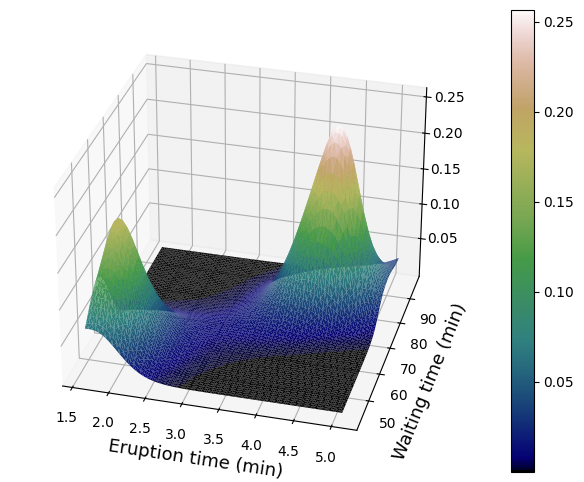

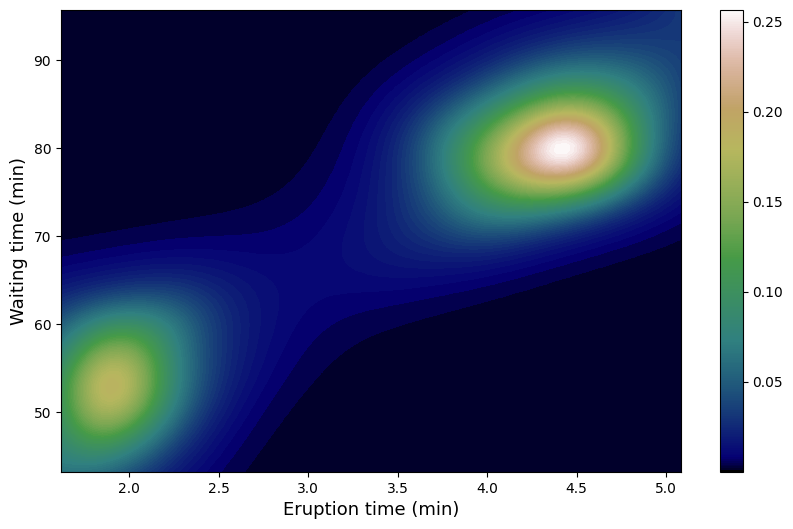

In [10]:
plot3 = SurfacesDisplay.from_estimator(
    example_3, orientation=(30, 285), figsize=(10, 6), **{"cmap": "gist_earth"}
)
for ax in (plot3.ax_, plot3.ax_contour_):
    _ = ax.set_xlabel("Eruption time (min)", fontsize=13)
    _ = ax.set_ylabel("Waiting time (min)", fontsize=13)

The `kyphosis` dataset contains real observations on children who had an
abnormally excessive convex curvature of the spine, and have undergone a
corrective spinal surgery. Hence, the columns are: 
* `Age`: Age of the child (in months).
* `Number`: the number of vertebrae involved.
* `Start`: the number of the first (topmost) vertebra operated on.
* `Kyphosis`: The categorical variable, with levels `present` and `absent`
  indicating if kyphosis was present after the operation. 

In [11]:
kyphosis = pd.read_csv("../data/kyphosis.csv")

Fit a smooth curve of the probability of kyphosis being present after the
operation through the age of the patient (`Age` vs `Kyphosis`) and plot the
results. 

In [12]:
example_4 = CPsplines(deg=(3,), ord_d=(2,), n_int=(20,), family="binomial")
example_4.fit(data=kyphosis[["Age", "Kyphosis"]], y_col="Kyphosis")

[Solve the problem with smoothing parameters (56.35551335138695,): ] Elapsed time (s): 0.051061


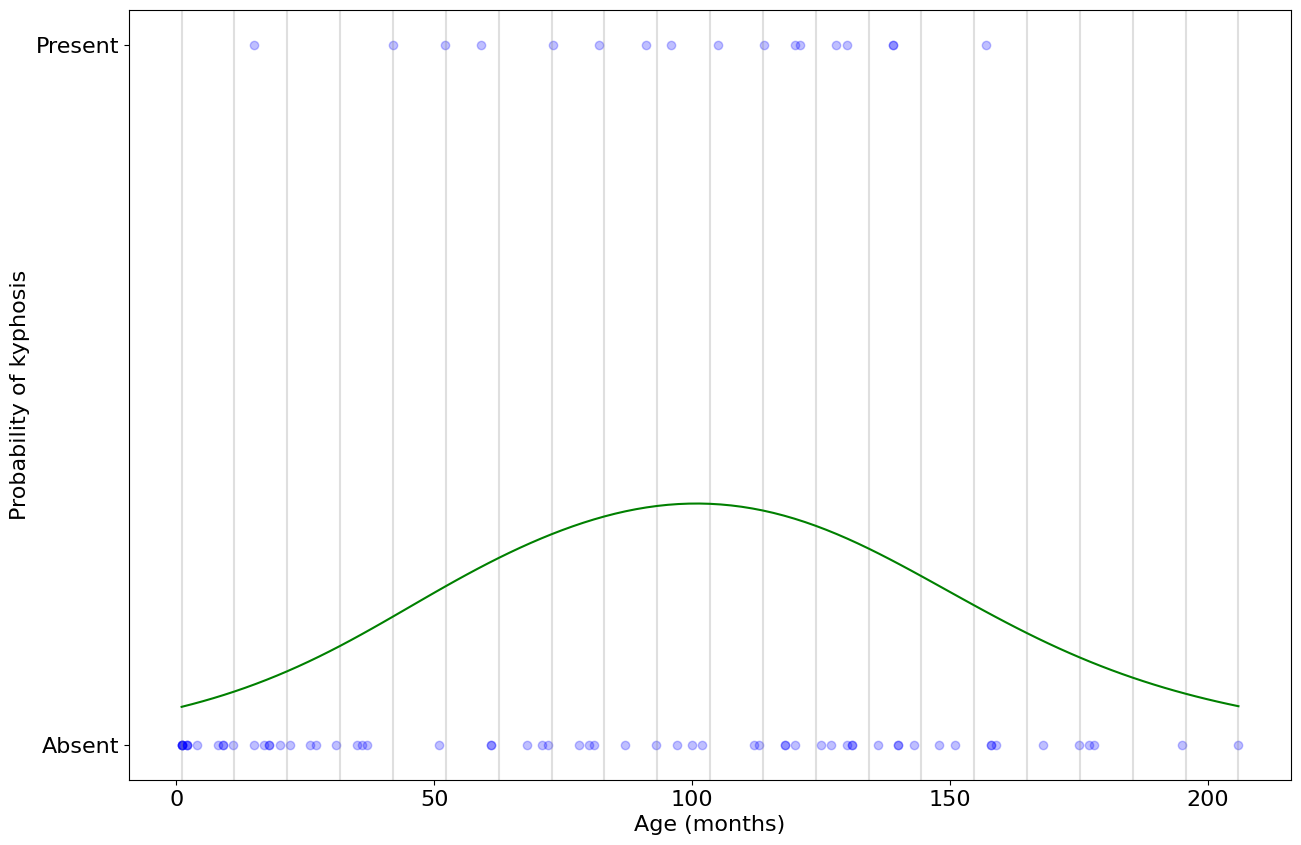

In [13]:
plot4 = CurvesDisplay.from_estimator(
    example_4,
    X=kyphosis["Age"],
    y=kyphosis["Kyphosis"],
    knot_positions=True,
    col_pt="b",
    **{"c": "g"}
)
_ = plot4.ax_.set_xlabel("Age (months)", fontsize=16)
_ = plot4.ax_.set_ylabel("Probability of kyphosis", fontsize=16)
_ = plot4.ax_.tick_params(axis="both", which="major", labelsize=16)

Fit a smooth surface of the probability of kyphosis being present after the
operation through the age of the patient and the number of the first vertebra
(`Start` and `Age`) and plot the results. 

In [14]:
example_5 = CPsplines(deg=(3, 3), ord_d=(2, 2), n_int=(15, 15), family="binomial")
example_5.fit(data=kyphosis[["Start", "Age", "Kyphosis"]], y_col="Kyphosis")

[Solve the problem with smoothing parameters (2.0825023468795885, 1.2287574235894156): ] Elapsed time (s): 0.111120


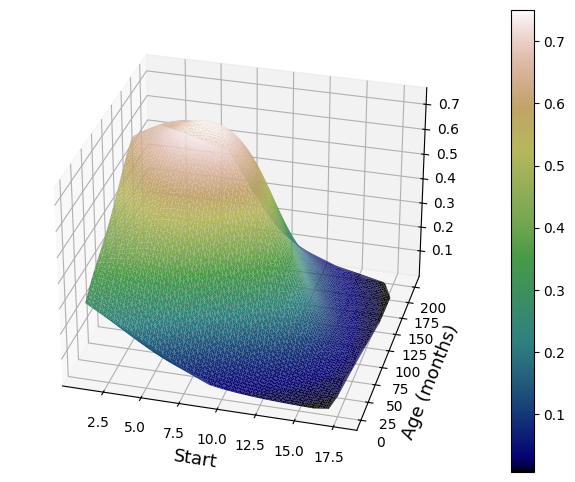

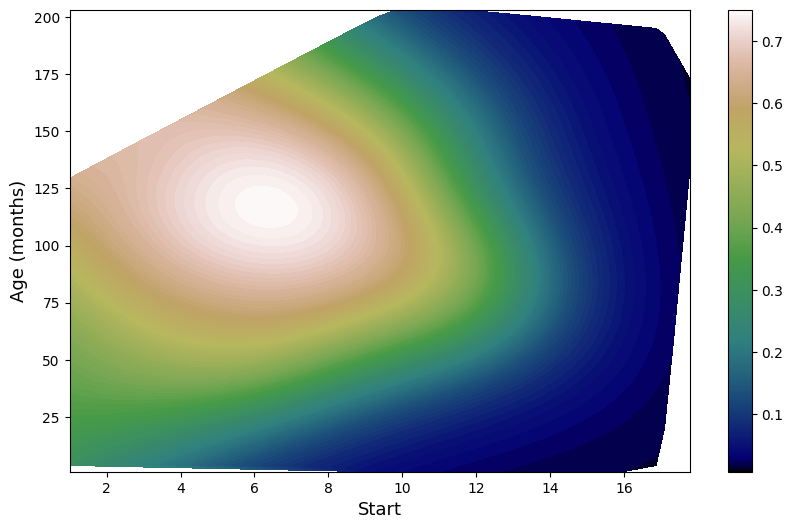

In [15]:
plot5 = SurfacesDisplay.from_estimator(
    example_5, orientation=(30, 285), figsize=(10, 6), **{"cmap": "gist_earth"}
)
for ax in (plot5.ax_, plot5.ax_contour_):
    _ = ax.set_xlabel("Start", fontsize=13)
    _ = ax.set_ylabel("Age (months)", fontsize=13)

To fit data using two-dimensional Binomial P-splines model, we generate a
dataset where the positive classification labels are assigned to the points
closer than a fixed radius from the origin. Then, a percentage of labels are
permuted to add some noise to the data.

In [16]:
def generate_polar_data(
    n: int, r: Union[int, float], perc: Union[int, float] = 0.2, seed: int = 0
) -> tuple[np.ndarray, np.ndarray]:
    """Generates a grid of points with separation an unit length in the square
    [-n, n] x [-n, n]. The points within the radius `r` are given a value 1,
    while a value 0 is assigned to the others. After that, a percentage `perc`
    of points permuted their values.

    Parameters
    ----------
    n : int
        Half of the length of the grid
    r : Union[int, float]
        The maximum radius of the points where the value 1 is assigned
    perc : Union[int, float], optional
        The percentage of values to be permuted, by default 0.2
    seed : int, optional
        The random state, by default 0

    Returns
    -------
    tuple[np.ndarray, np.ndarray]
        The first element of the tuple is the sequence of positions where the
        points of the grid are (as it is a squared grid, the horizontal and
        vertical coincide). The second element of the tuple is a binary matrix
        with the generated data.
    """
    # Generate the grid
    xy_grid = np.concatenate(
        (
            np.tile(np.linspace(-n, n, 2 * n + 1), 2 * n + 1).reshape(
                ((2 * n + 1) ** 2, 1)
            ),
            np.repeat(np.linspace(-n, n, 2 * n + 1), 2 * n + 1).reshape(
                ((2 * n + 1) ** 2, 1)
            ),
        ),
        axis=1,
    )
    # Create an auxiliar DataFrame with the x-y coordinates and the distance to
    # the origin
    df_aux = pd.concat(
        (
            pd.DataFrame(xy_grid, columns=["x_coord", "y_coord"]),
            pd.Series(
                np.apply_along_axis(np.linalg.norm, 1, xy_grid) < r, name="pred"
            ).astype(int),
        ),
        axis=1,
    )
    # Shuffle the desired percentage of values and assign the new values to the
    # auxiliar DataFrame
    np.random.seed(seed)
    rand_ix = np.random.choice(
        len(df_aux), size=int(perc * (2 * n + 1) ** 2), replace=False
    )
    rand_vals = df_aux["pred"].values.flatten()[rand_ix]
    np.random.shuffle(rand_vals)
    df_aux["pred"].values[rand_ix] = rand_vals
    # To get the desired matrix, pivot the DataFrame
    return (
        np.linspace(-n, n, 2 * n + 1),
        df_aux.pivot(columns="y_coord", index="x_coord", values="pred").values,
    )

In [17]:
threshold = 0.5  # Probability threshold
n = 10
r = 7
perc = 0.2

x, y = generate_polar_data(n=n, r=r, perc=perc)
data6 = grid_to_scatter(x=(x, x), y=y).astype({"y": int})

example_6 = CPsplines(deg=(3, 3), ord_d=(2, 2), n_int=(8, 8), family="binomial")
example_6.fit(data=data6, y_col="y")

[Solve the problem with smoothing parameters (0.05283013906094336, 1.000000082740371e-10): ] Elapsed time (s): 0.325846


As this is a classification problem, we can compute metrics as the confusion matrix:

In [18]:
conf_matrix = pd.crosstab(
    y.flatten(),
    np.where(example_6.predict(data6.drop(columns="y")) < threshold, 0, 1).flatten(),
)
conf_matrix.columns.name = None
conf_matrix.index.name = None
conf_matrix

,0,1
0,278,18
1,16,129


Now, we plot the results. The blue points corresponds to the true negative
classifications, while the red ones are referred to the true positive. In the
background of the plot and with the same representative colours, the predicted
classification boundaries are depicted. 

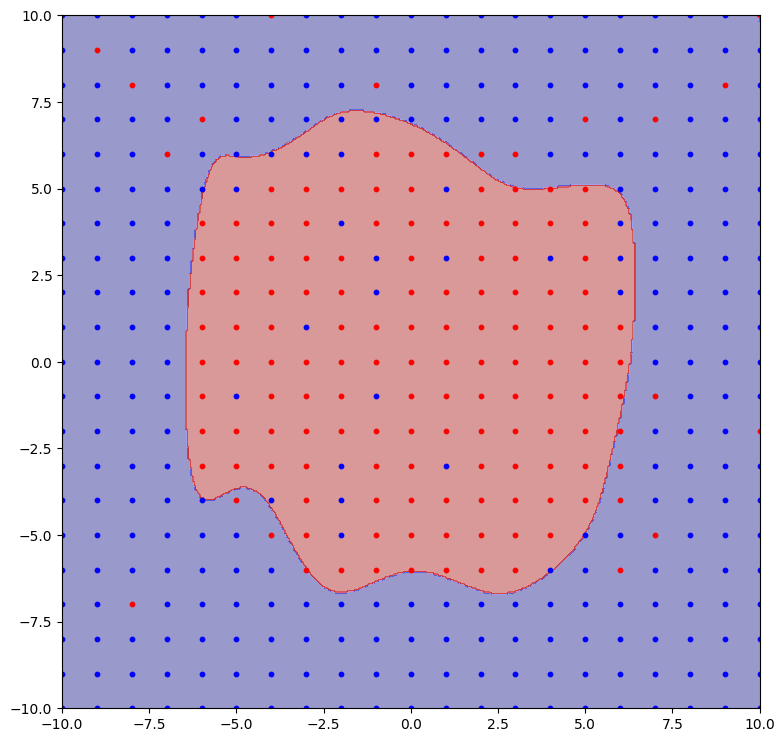

In [19]:
x_pred = np.linspace(-n, n, 501)
X, Y = np.meshgrid(x_pred, x_pred)

fig, ax = plt.subplots(figsize=(9, 9))
surf = ax.contourf(
    X,
    Y,
    np.where(
        example_6.predict(
            data=pd.DataFrame(
                {"x1": np.repeat(x_pred, 501), "x2": np.tile(x_pred, 501)}
            )
        )
        < threshold,
        0,
        1,
    ).reshape((501, 501)),
    cmap="seismic",
    alpha=0.4,
)
_ = ax.scatter(np.where(y == 1)[0] - n, np.where(y == 1)[1] - n, c="red", alpha=1, s=10)
_ = ax.scatter(
    np.where(y == 0)[0] - n, np.where(y == 0)[1] - n, c="blue", alpha=1, s=10
)

We fit another example for two-dimensional Binomial data by generating two
interleaving "moons" and adding Gaussian noise.

In [20]:
def make_moons(
    n_samples: int = 100, scale: Union[int, float] = 0.1, random_state: int = 1
) -> tuple[np.ndarray, np.ndarray]:
    """Make two interleaving half circles. This is a simplified version of
    `make_moons` [1] from `sklearn`.

    Parameters
    ----------
    n_samples : int, optional
        The total number of points generated, by default 100
    scale : float, optional
        Standard deviation of Gaussian noise added to the data, by default 0.1
    random_state : int, optional
        Determines random number generation for noise, by default 1

    Returns
    -------
    tuple[np.ndarray, np.ndarray]
    A tuple with the generated samples and the integer labels  (0 or 1) for
    class membership of each sample.

    References
    ----------
    ..[1] https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_moons.html
    """

    if n_samples % 2 != 0:
        raise ValueError("Provide an even value for `n_samples`")

    outer_x = np.cos(np.linspace(0, np.pi, int(n_samples / 2)))
    outer_y = np.sin(np.linspace(0, np.pi, int(n_samples / 2)))
    inner_x = 1 - np.cos(np.linspace(0, np.pi, int(n_samples / 2)))
    inner_y = 1 - np.sin(np.linspace(0, np.pi, int(n_samples / 2))) - 0.5

    np.random.seed(random_state)
    X = np.vstack(
        [np.append(outer_x, inner_x), np.append(outer_y, inner_y)]
    ).T + np.random.normal(loc=0, scale=scale, size=(n_samples, 2))
    y = np.hstack(
        [
            np.zeros(int(n_samples / 2), dtype=np.int8),
            np.ones(int(n_samples / 2), dtype=np.int8),
        ]
    )

    return X, y

In [21]:
X, y = make_moons(n_samples=100, scale=0.15, random_state=42)
data7 = pd.DataFrame(
    np.concatenate([X, y[:, np.newaxis]], axis=1), columns=["x0", "x1", "y"]
).astype({"y": int})
threshold = 0.5

example_7 = CPsplines(deg=(3, 3), ord_d=(2, 2), n_int=(10, 10), family="binomial")
example_7.fit(data=data7, y_col="y")

/home/manuel/miniconda3/envs/cpsplines/lib/python3.9/site-packages/scipy/optimize/_optimize.py:404: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


[Solve the problem with smoothing parameters (9.532836039420836e-07, 0.9020415207493848): ] Elapsed time (s): 0.145500


As this is a classification problem, we can compute metrics as the confusion matrix:

In [22]:
conf_matrix = pd.crosstab(
    y, np.where(example_7.predict(data7.drop(columns="y")) < threshold, 0, 1)
)
conf_matrix.columns.name = None
conf_matrix.index.name = None
conf_matrix

,0,1
0,50,0
1,0,50


Finally, we plot the decisions boundary of the problem:

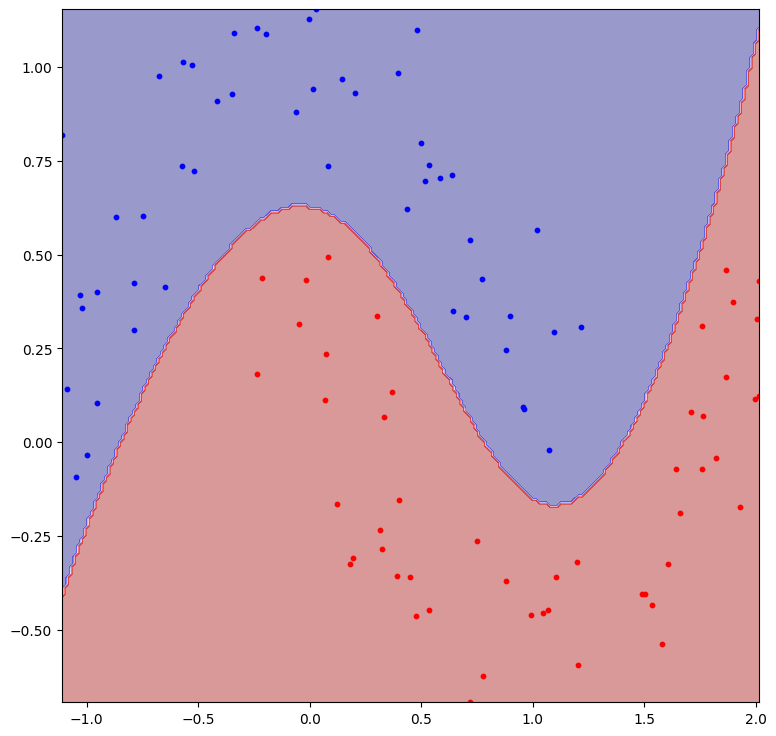

In [23]:
x_pred = np.repeat(
    np.linspace(data7.loc[:, "x0"].min(), data7.loc[:, "x0"].max(), 201), 201
)
y_pred = np.tile(
    np.linspace(data7.loc[:, "x1"].min(), data7.loc[:, "x1"].max(), 201), 201
)

df = (
    pd.DataFrame({"x1": x_pred, "x2": y_pred})
    .assign(
        y=np.where(
            example_7.predict(pd.DataFrame({"x1": x_pred, "x2": y_pred})) < threshold,
            0,
            1,
        )
    )
    .groupby(["x1", "x2"])
    .mean()
    .reset_index()
    .set_axis(["x1", "x2", "y"], axis=1)
    .pivot(index="x1", columns="x2", values="y")
)
X, Y = np.meshgrid(df.columns.values, df.index.values)

fig, ax = plt.subplots(figsize=(9, 9))
_ = ax.contourf(Y, X, df.values, cmap="seismic", alpha=0.4)
_ = ax.scatter(
    data7.query("y == 0")["x0"], data7.query("y == 0")["x1"], c="blue", alpha=1, s=10
)
_ = ax.scatter(
    data7.query("y == 1")["x0"], data7.query("y == 1")["x1"], c="red", alpha=1, s=10
)